In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames[:5]:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/invasivespecies/test/1269.jpg
/kaggle/input/invasivespecies/test/623.jpg
/kaggle/input/invasivespecies/test/764.jpg
/kaggle/input/invasivespecies/test/1075.jpg
/kaggle/input/invasivespecies/test/771.jpg
/kaggle/input/invasivespecies/train/1269.jpg
/kaggle/input/invasivespecies/train/623.jpg
/kaggle/input/invasivespecies/train/2193.jpg
/kaggle/input/invasivespecies/train/2008.jpg
/kaggle/input/invasivespecies/train/2081.jpg
/kaggle/input/invasive-species-monitoring/train_labels.csv.zip
/kaggle/input/invasive-species-monitoring/sample_submission.csv.zip
/kaggle/input/invasive-species-monitoring/test.7z
/kaggle/input/invasive-species-monitoring/train.7z


In [2]:
# train 데이터 압축풀기
!unzip -q -o '/kaggle/input/invasive-species-monitoring/train_labels.csv.zip'
train = pd.read_csv('./train_labels.csv')
train

,name,invasive
0,1,0
1,2,0
2,3,1
3,4,0
4,5,1
...,...,...
2290,2291,1
2291,2292,1
2292,2293,1
2293,2294,1


In [3]:
# 경로 찾기
import glob
len(glob.glob("/kaggle/input/invasivespecies/train/*"))
#len(glob.glob("test/*"))

# 데이터 프레임 만들기 (경로와 라벨)
train['name'] = '/kaggle/input/invasivespecies/train/' + train['name'].astype('str') + '.jpg'
train['invasive'] = train['invasive'].astype('str')
train

,name,invasive
0,/kaggle/input/invasivespecies/train/1.jpg,0
1,/kaggle/input/invasivespecies/train/2.jpg,0
2,/kaggle/input/invasivespecies/train/3.jpg,1
3,/kaggle/input/invasivespecies/train/4.jpg,0
4,/kaggle/input/invasivespecies/train/5.jpg,1
...,...,...
2290,/kaggle/input/invasivespecies/train/2291.jpg,1
2291,/kaggle/input/invasivespecies/train/2292.jpg,1
2292,/kaggle/input/invasivespecies/train/2293.jpg,1
2293,/kaggle/input/invasivespecies/train/2294.jpg,1


In [33]:
# 검증단계 만들기
from sklearn.model_selection import train_test_split

x_train , x_valid = train_test_split(train, test_size=0.2, random_state=42)

In [34]:
from keras.preprocessing.image import ImageDataGenerator

idg = ImageDataGenerator(horizontal_flip=True) # 데이터증식 : 1)이미지좌우반전

train_generator = idg.flow_from_dataframe(x_train, x_col='name', y_col='invasive', target_size=(300,300), batch_size=32)
valid_generator = idg.flow_from_dataframe(x_valid, x_col='name', y_col='invasive', target_size=(300,300), batch_size=32)

Found 1836 validated image filenames belonging to 2 classes.
Found 459 validated image filenames belonging to 2 classes.


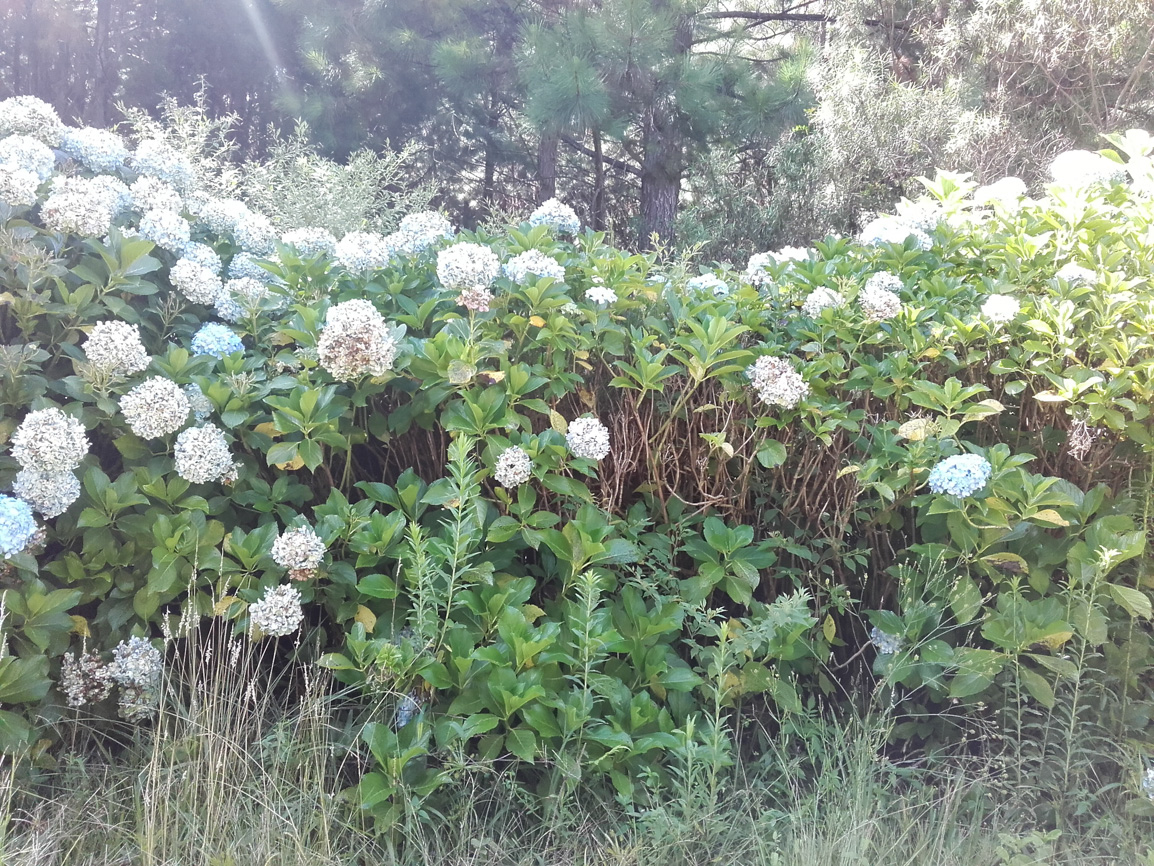

In [6]:
from PIL import Image
Image.open('/kaggle/input/invasivespecies/train/3.jpg')

In [37]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0 
from keras import *
from keras.layers import *

model = Sequential()

model.add(EfficientNetB0(weights='imagenet', include_top=False, pooling='avg')) # 'pooling'
model.add(Dense(2,activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 1280)              4049571   
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 2562      
Total params: 4,052,133
Trainable params: 4,010,110
Non-trainable params: 42,023
_________________________________________________________________


In [38]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

es = EarlyStopping(patience=3, verbose=1) # 점수가 점점 안좋아지면 2번까지 참고 일찍 끊음
mc = ModelCheckpoint('best.h5', save_best_only=True, verbose=1) # 최적의 순간을 저장, 학습한 것 중 제일 성능 좋은 것만 저장하자!!
rl = ReduceLROnPlateau(patience=2, verbose=1)

# 모델 선언 마무리
model.compile(metrics=['acc'], loss='categorical_crossentropy', optimizer='adam')
model.fit(train_generator, validation_data = valid_generator, epochs=100, # epochs 학습횟수 지정, 기본은 1
          callbacks=[es,mc,rl])
model.load_weights('best.h5')

Epoch 1/100
58/58 [==============================] - 74s 1s/step - loss: 0.2465 - acc: 0.8686 - val_loss: 0.7534 - val_acc: 0.8736

Epoch 00001: val_loss improved from inf to 0.75345, saving model to best.h5
Epoch 2/100
58/58 [==============================] - 65s 1s/step - loss: 0.0490 - acc: 0.9923 - val_loss: 0.5005 - val_acc: 0.9041

Epoch 00002: val_loss improved from 0.75345 to 0.50050, saving model to best.h5
Epoch 3/100
58/58 [==============================] - 66s 1s/step - loss: 0.0379 - acc: 0.9860 - val_loss: 0.4607 - val_acc: 0.8976

Epoch 00003: val_loss improved from 0.50050 to 0.46072, saving model to best.h5
Epoch 4/100
58/58 [==============================] - 65s 1s/step - loss: 0.0688 - acc: 0.9767 - val_loss: 0.0970 - val_acc: 0.9760

Epoch 00004: val_loss improved from 0.46072 to 0.09701, saving model to best.h5
Epoch 5/100
58/58 [==============================] - 64s 1s/step - loss: 0.0315 - acc: 0.9906 - val_loss: 0.0750 - val_acc: 0.9847

Epoch 00005: val_loss im

In [17]:
# 예측
test = pd.DataFrame({'name':glob.glob("/kaggle/input/invasivespecies/test/*")})

idg2 = ImageDataGenerator()

# test_generator 만들때 옵션 두가지 더! (class_mode, shuffle=False)
test_generator = idg2.flow_from_dataframe(test, x_col='name', y_col=None, 
                                          target_size=(300,300), batch_size=32, 
                                          class_mode=None, shuffle=False)

Found 1531 validated image filenames.


In [18]:
!unzip -q -o '/kaggle/input/invasive-species-monitoring/sample_submission.csv.zip'
sub = pd.read_csv('./sample_submission.csv')
sub

,name,invasive
0,1,0.5
1,2,0.5
2,3,0.5
3,4,0.5
4,5,0.5
...,...,...
1526,1527,0.5
1527,1528,0.5
1528,1529,0.5
1529,1530,0.5


In [19]:
result = model.predict(test_generator, verbose=1)

48/48 [==============================] - 63s 1s/step


In [20]:
result

array([[4.7505213e-04, 9.9952495e-01],
       [3.3691209e-02, 9.6630883e-01],
       [5.9346687e-03, 9.9406528e-01],
       ...,
       [5.1065400e-04, 9.9948931e-01],
       [9.4942532e-02, 9.0505743e-01],
       [9.6448565e-01, 3.5514381e-02]], dtype=float32)

In [21]:
sub['invasive'] = result[:,1]
sub

,name,invasive
0,1,0.999525
1,2,0.966309
2,3,0.994065
3,4,0.984890
4,5,0.992618
...,...,...
1526,1527,0.993725
1527,1528,0.994155
1528,1529,0.999489
1529,1530,0.905057


In [22]:
test

,name
0,/kaggle/input/invasivespecies/test/1269.jpg
1,/kaggle/input/invasivespecies/test/623.jpg
2,/kaggle/input/invasivespecies/test/764.jpg
3,/kaggle/input/invasivespecies/test/1075.jpg
4,/kaggle/input/invasivespecies/test/771.jpg
...,...
1526,/kaggle/input/invasivespecies/test/25.jpg
1527,/kaggle/input/invasivespecies/test/1201.jpg
1528,/kaggle/input/invasivespecies/test/147.jpg
1529,/kaggle/input/invasivespecies/test/921.jpg


In [27]:
sub['name'] = test['name'].apply(lambda x : x.split('/')[5].split('.')[0])
sub

,name,invasive
0,1269,0.999525
1,623,0.966309
2,764,0.994065
3,1075,0.984890
4,771,0.992618
...,...,...
1526,25,0.993725
1527,1201,0.994155
1528,147,0.999489
1529,921,0.905057


In [28]:
sub.to_csv('sub.csv',index=0)